# Problem Statement

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

1. Thumbs up:  Increase the volume
2. Thumbs down: Decrease the volume
3. Left swipe: 'Jump' backwards 10 seconds
4. Right swipe: 'Jump' forward 10 seconds  
5. Stop: Pause the movie

# Goals of this Project

To accomplish the following:

1. Generator:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. Model: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. Write up: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
# If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize
#from scipy.misc import imread, imresize
import datetime
import os
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.applications import mobilenet
from keras.layers import Dense, GRU, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,GlobalAveragePooling3D, LayerNormalization 
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [ ]:
# Unzip the data in the 'Project_data' zip folder

# !unzip "/content/gdrive/MyDrive/DL_Course_Project/Project_data.zip"
# !ls


We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30) this code is throwing an error: AttributeError: module 'tensorflow' has no attribute 'set_random_seed' on 
tf.random.set_seed(30)

In [ ]:
tf. __version__ #prints the tensorflow version
# This project is made with tensorflow version 2.8.2

'2.8.2'

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/DL_Course_Project/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/DL_Course_Project/Project_data/val.csv').readlines())
batch_size = 20 

In [ ]:
# function to plot the training/validation accuracies/losses.

from IPython.display import Markdown, display
from matplotlib import pyplot as plt

def plot_metrics(metrics):
    display(Markdown("**Training Accuracy:** " + str(round(metrics.history['categorical_accuracy'][num_epochs-1], 2))))
    display(Markdown("**Validation Accuracy:** " + str(round(metrics.history['val_categorical_accuracy'][num_epochs-1], 2))))

    acc = metrics.history['categorical_accuracy']
    val_acc = metrics.history['val_categorical_accuracy']

    loss = metrics.history['loss']
    val_loss = metrics.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
# global declaration of input sequence properties as used for the generator.
total_count_frames = 30
selected_frames = 15
image_height = 120
image_width = 120

In [ ]:
# Custom code to cropping and resizing
def image_crop_resize(image):
    if image.shape[0] > 120 and image.shape[1] > 120:
        image = resize(image, (120, 120))
        
    height = image.shape[0]
    width = image.shape[1]
    height_center = height//2
    width_center = width//2
    image = image[(height_center-60):(height_center+70), (width_center-50):(width_center+70)]
    image = resize(image,(image_height, image_width))
    return image

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0, total_count_frames-1, selected_frames)).astype(int) #create a list of image numbers you want to use for a particular video
    
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(source_path)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,selected_frames,image_height,image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes             
                    
                    resized_image = image_crop_resize(image)
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches

        if((len(source_path)%batch_size)//2==0):
          internal_batch_size = 2
        else:
          internal_batch_size = 1

        num_batches_left = len(source_path) % internal_batch_size # calculate the number of leftout batch passes
        for batch in range(num_batches_left): # we iterate over the number of batches left
          batch_data = np.zeros((internal_batch_size,selected_frames,image_height,image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB x,y,z = 18,84,84
          batch_labels = np.zeros((internal_batch_size,5)) # batch_labels is the one hot representation of the output
          for folder in range(internal_batch_size): # iterate over the internal batch_size
            imgs = os.listdir(source_path+'/'+ t[folder + (num_batches_left*internal_batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx):
              image_leftout = imread(source_path+'/'+ t[folder + (num_batches_left*internal_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
              
              leftout_resized_image = image_crop_resize(image_leftout)

              batch_data[folder,idx,:,:,0] = (leftout_resized_image[:,:,0])/255 #normalise and feed in the image
              batch_data[folder,idx,:,:,1] = (leftout_resized_image[:,:,1])/255 #normalise and feed in the image
              batch_data[folder,idx,:,:,2] = (leftout_resized_image[:,:,2])/255 #normalise and feed in the image
                    
            batch_labels[folder, int(t[folder + (batch*internal_batch_size)].strip().split(';')[2])] = 1 
          yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do




Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

Why are we using datetime?

Because we will be creating multiple models and we dont wish to overwrite a new model over the older one. Therefore, saving it along with the timestamp helps.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/DL_Course_Project/Project_data/train'
val_path = '/content/drive/MyDrive/DL_Course_Project/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Conv3D
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

#### Initial Model

In [ ]:
# model_1 = Sequential()

# model_1.add(Conv3D(64,3, activation='elu', padding='same', input_shape=(10,120,120,3)))

# model_1.add(BatchNormalization(axis=-1))
# model_1.add(MaxPooling3D(pool_size=(2,2,2)))

# model_1.add(Conv3D(64,3,activation='elu',padding='same'))
# model_1.add(BatchNormalization(axis=-1))
# model_1.add(MaxPooling3D(pool_size=(2,2,2)))

# model_1.add(Conv3D(128,(3,3,3),activation='elu',padding='same'))
# model_1.add(BatchNormalization())
# model_1.add(MaxPooling3D(pool_size=(2,2,1)))
# model_1.add(Dropout(0.25))

# model_1.add(GlobalAveragePooling3D())
# model_1.add(Dropout(0.25))
# model_1.add(Dense(512, activation ='elu'))
# model_1.add(BatchNormalization())
# model_1.add(Dense(256, activation ='elu'))
# model_1.add(BatchNormalization())
# model_1.add(Dense(5,activation='softmax'))

#### Initial Model Summary

In [ ]:
# optimiser = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
# model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 120, 120, 64)  5248      
                                                                 
 batch_normalization (BatchN  (None, 10, 120, 120, 64)  256      
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 60, 60, 64)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 60, 60, 64)     110656    
                                                                 
 batch_normalization_1 (Batc  (None, 5, 60, 60, 64)    256       
 hNormalization)                                                 
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


#### Second Model

In [ ]:
# model_1 = Sequential()

# model_1.add(Conv3D(64,3, activation='elu', padding='same', input_shape=(18,84,84,3)))

# #axis =-1 identifies the channel axis on which normalization should not be done, since ours is channel_last so setting it to -1.
# model_1.add(BatchNormalization(axis = -1))
# model_1.add(MaxPooling3D(pool_size=(2,2,2)))

# model_1.add(Conv3D(64,3,activation='elu',padding='same'))
# model_1.add(BatchNormalization(axis = -1))
# model_1.add(MaxPooling3D(pool_size=(2,2,2)))

# model_1.add(Conv3D(128,(3,3,3),activation='elu',padding='same'))
# model_1.add(BatchNormalization(axis = -1))
# model_1.add(MaxPooling3D(pool_size=(2,2,1)))
# model_1.add(Dropout(0.25))

# model_1.add(GlobalAveragePooling3D())
# model_1.add(Dropout(0.25))
# model_1.add(Dense(512, activation ='elu'))
# model_1.add(BatchNormalization(axis = -1))
# model_1.add(Dense(256, activation ='elu'))
# model_1.add(BatchNormalization(axis = -1))
# model_1.add(Dense(5,activation='softmax'))

#### Second Model Summary

In [ ]:
# optimiser = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.5, nesterov=True) #write your optimizer
# model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model_1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 18, 84, 84, 64)    5248      
                                                                 
 batch_normalization_10 (Bat  (None, 18, 84, 84, 64)   256       
 chNormalization)                                                
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 9, 42, 42, 64)    0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 9, 42, 42, 64)     110656    
                                                                 
 batch_normalization_11 (Bat  (None, 9, 42, 42, 64)    256       
 chNormalization)                                                
                                                      

#### Final Model

In [ ]:
model_1 = Sequential()

model_1.add(Conv3D(32,3, use_bias=False, padding="same", input_shape=(selected_frames,image_height,image_width,3)))
model_1.add(LayerNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(3,strides=2, padding="same"))

model_1.add(Conv3D(64,3, use_bias=False, padding="same"))
model_1.add(LayerNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(3,strides=2, padding="same"))

model_1.add(Conv3D(128,3, use_bias=False, padding="same"))
model_1.add(LayerNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(3,strides=2, padding="same"))

model_1.add(Conv3D(256,3, use_bias=False, padding="same"))
model_1.add(LayerNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(3,strides=2, padding="same"))

model_1.add(GlobalAveragePooling3D())
model_1.add(Dense(512))
model_1.add(LayerNormalization())
model_1.add(Activation('relu'))
model_1.add(Dense(5, activation ='softmax'))

#### Final Model Summary

In [ ]:
optimiser = tf.keras.optimizers.Adam() #write your optimizer
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 32)  2592      
                                                                 
 layer_normalization (LayerN  (None, 15, 120, 120, 32)  64       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 15, 120, 120, 32)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 60, 60, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 60, 60, 64)     55296     
                                                                 
 layer_normalization_1 (Laye  (None, 8, 60, 60, 64)    1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                      mode="min", epsilon=0.0001,
                      cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

#### Initial Conv3D model run result

In [ ]:
# model_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/drive/MyDrive/DL_Course_Project/Project_data/train ; batch size = 25
Epoch 1/15
27/27 [==============================] - ETA: 0s - loss: 1.6533 - categorical_accuracy: 0.3852  Source path =  /content/drive/MyDrive/DL_Course_Project/Project_data/val ; batch size = 25

Epoch 1: saving model to model_init_2022-08-1110_34_12.862148/model-00001-1.65331-0.38519-1.61695-0.25000.h5
27/27 [==============================] - 3312s 127s/step - loss: 1.6533 - categorical_accuracy: 0.3852 - val_loss: 1.6170 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/15
27/27 [==============================] - ETA: 0s - loss: 1.2620 - categorical_accuracy: 0.4770 
Epoch 2: saving model to model_init_2022-08-1110_34_12.862148/model-00002-1.26199-0.47704-1.79808-0.27000.h5
27/27 [==============================] - 1238s 48s/step - loss: 1.2620 - categorical_accuracy: 0.4770 - val_loss: 1.7981 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/15
27/27 [==========================

#### Second Model Output

In [ ]:
# model_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/DL_Course_Project/Project_data/train ; batch size = 15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/30
45/45 [==============================] - ETA: 0s - loss: 1.6644 - categorical_accuracy: 0.3511 Source path =  /content/drive/MyDrive/DL_Course_Project/Project_data/val ; batch size = 15

Epoch 1: saving model to model_init_2022-08-1212_27_53.626149/model-00001-1.66437-0.35111-1.67875-0.17143.h5
45/45 [==============================] - 3062s 69s/step - loss: 1.6644 - categorical_accuracy: 0.3511 - val_loss: 1.6787 - val_categorical_accuracy: 0.1714 - lr: 0.0010
Epoch 2/30
45/45 [==============================] - ETA: 0s - loss: 1.2583 - categorical_accuracy: 0.4667 
Epoch 2: saving model to model_init_2022-08-1212_27_53.626149/model-00002-1.25832-0.46667-2.22032-0.12381.h5
45/45 [==============================] - 1234s 28s/step - loss: 1.2583 - categorical_accuracy: 0.4667 - val_loss: 2.2203 - val_categorical_accuracy: 0.1238 - lr: 0.0010
Epoch 3/30
45/45 [==============================] - ETA: 0s - loss: 1.2464 - categorical_accuracy: 0.4859
Epoch 3: saving model to model_in

# Final Conv3D Model

In [ ]:
model1_metrics = model_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/drive/MyDrive/DL_Course_Project/Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.8844 - categorical_accuracy: 0.2059 Source path =  /content/drive/MyDrive/DL_Course_Project/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-08-1314_35_08.114078/model-00001-1.88444-0.20588-1.71884-0.26000.h5
34/34 [==============================] - 1990s 60s/step - loss: 1.8844 - categorical_accuracy: 0.2059 - val_loss: 1.7188 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.6535 - categorical_accuracy: 0.2206 
Epoch 2: saving model to model_init_2022-08-1314_35_08.114078/model-00002-1.65351-0.22059-1.65913-0.30000.h5
34/34 [==============================] - 840s 25s/step - loss: 1.6535 - categorical_accuracy: 0.2206 - val_loss: 1.6591 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/30
34/34 [=============================

**Training Accuracy:** 0.94%

**Validation Accuracy:** 0.89%

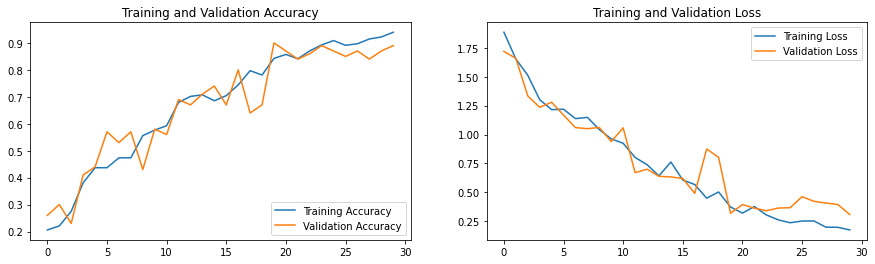

In [ ]:
plot_metrics(model1_metrics)

# CNN+RNN models



In [ ]:
# train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
# val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())
batch_size = 32

In [ ]:
# Global Parameters for the models

total_count_frames = 30
selected_frames = 15
gestures = 5
image_height = 120
image_width = 120
img_idx = np.round(np.linspace(0, total_count_frames-1, selected_frames)).astype(int) #create a list of image numbers you want to use for a particular video


In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/Project_data/train'
val_path = '/content/Project_data/val'
num_train_sequences = len(train_doc) # 663
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc) # 100
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


# Model 1:- VGG16

In [ ]:
# from keras.models import Sequential, Model
# from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
# from keras.layers.convolutional import Conv3D, MaxPooling3D
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# from keras import optimizers

# #write your model here
# from keras.applications.vgg16 import VGG16
# base_model = VGG16(include_top=False, weights='imagenet', input_shape=(image_height, image_width, 3))
# x = base_model.output
# x = Flatten()(x)
# # x.add(Dropout(0.5))

# features = Dense(64, activation='relu')(x)
# conv_model = Model(inputs=base_model.input, outputs=features)

# for layer in base_model.layers:
#     layer.trainable = False

# model = Sequential()
# model.add(TimeDistributed(conv_model, input_shape=(len(img_idx), image_height, image_width, 3)))
# model.add(GRU(64, return_sequences=True))
# model.add(GRU(32, return_sequences=True))
# model.add(GRU(16))
# #model.add(Dropout(0.5))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(5, activation='softmax'))


58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# optimiser = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
# model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 64)           15009664  
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 15, 64)            24960     
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            9408      
                                                                 
 gru_2 (GRU)                 (None, 16)                2400      
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 5)                 45        
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# optimiser = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
# model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 64)           15009664  
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 15, 64)            24960     
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            9408      
                                                                 
 gru_2 (GRU)                 (None, 16)                2400      
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 5)                 45        
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# train_generator = generator(train_path, train_doc, batch_size)
# val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
# model_name = 'model_init_exp1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
# if not os.path.exists(model_name):
#     os.mkdir(model_name)
        
# filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# # ModelCheckpoint - saves weight and model after every epoch
# LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
#                       mode="min", epsilon=0.0001,
#                       cooldown=0, min_lr=0.00001) 
# callbacks_list = [checkpoint, LR]

In [ ]:
# if (num_train_sequences%batch_size) == 0:
#     steps_per_epoch = int(num_train_sequences/batch_size)
# else:
#     steps_per_epoch = (num_train_sequences//batch_size) + 1
# if (num_val_sequences%batch_size) == 0:
#     validation_steps = int(num_val_sequences/batch_size)
# else:
#     validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# metrics1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.6270 - categorical_accuracy: 0.2278Source path =  /content/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_exp1_2022-08-1212_43_51.281419/model-00001-1.62704-0.22775-1.59792-0.27000.h5
21/21 [==============================] - 157s 6s/step - loss: 1.6270 - categorical_accuracy: 0.2278 - val_loss: 1.5979 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5623 - categorical_accuracy: 0.2981
Epoch 2: saving model to model_init_exp1_2022-08-1212_43_51.281419/model-00002-1.56233-0.29814-1.55876-0.25000.h5
21/21 [==============================] - 86s 4s/step - loss: 1.5623 - categorical_accuracy: 0.2981 - val_loss: 1.5588 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.4781 - categorical_accuracy: 0.4265
E

**Training Accuracy:** 0.76%

**Validation Accuracy:** 0.38%

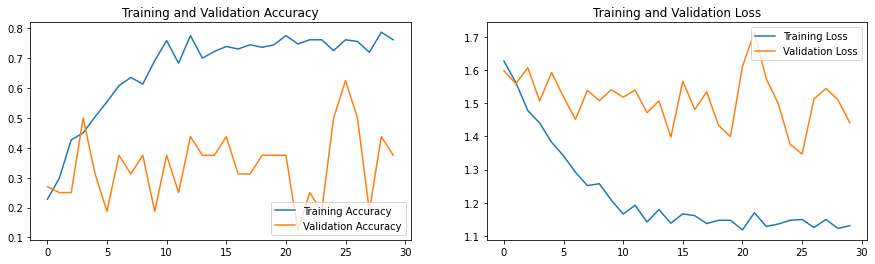

In [ ]:
# plot_metrics(metrics1)

# Model 2:- CNN+LSTM with 'Adam' optimizer 

In [ ]:
total_count_frames = 30
selected_frames = 15
gestures = 5
image_height = 120
image_width = 120
img_idx = np.round(np.linspace(0, total_count_frames-1, selected_frames)).astype(int)

In [ ]:
train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())
batch_size = 8

In [ ]:
# from keras.models import Sequential, Model
# from keras.layers import Conv2D,MaxPooling2D
# from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
# from keras.layers.convolutional import Conv3D, MaxPooling3D
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# from keras import optimizers
# from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, Bidirectional

# model = Sequential()
# model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
#                                   input_shape=(len(img_idx), image_height, image_width, 3)))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
 
# model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
 
# model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
 
# model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
 
 
# model.add(TimeDistributed(Flatten()))

# model.add(LSTM(128))
# model.add(Dropout(0.25))
 
# model.add(Dense(128,activation='relu'))
# model.add(Dropout(0.25))
        
# model.add(Dense(5, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
# optimiser = tf.keras.optimizers.Adam() #write your optimizer
# model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 60, 60, 32)   1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
# train_generator = generator(train_path, train_doc, batch_size)
# val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
# model_name = 'model_init_exp2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
# if not os.path.exists(model_name):
#     os.mkdir(model_name)
        
# filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# # ModelCheckpoint - saves weight and model after every epoch
# LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
#                       mode="min", epsilon=0.0001,
#                       cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
# callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:

# if (num_train_sequences%batch_size) == 0:
#     steps_per_epoch = int(num_train_sequences/batch_size)
# else:
#     steps_per_epoch = (num_train_sequences//batch_size) + 1
# if (num_val_sequences%batch_size) == 0:
#     validation_steps = int(num_val_sequences/batch_size)
# else:
#     validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
# metrics2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/Project_data/train ; batch size = 8
Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 1.3877 - categorical_accuracy: 0.3816Source path =  /content/Project_data/val ; batch size = 8

Epoch 1: saving model to model_init_exp2_2022-08-1215_43_48.191700/model-00001-1.38769-0.38160-1.64901-0.28000.h5
83/83 [==============================] - 150s 2s/step - loss: 1.3877 - categorical_accuracy: 0.3816 - val_loss: 1.6490 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 1.2595 - categorical_accuracy: 0.4320
Epoch 2: saving model to model_init_exp2_2022-08-1215_43_48.191700/model-00002-1.25945-0.43201-1.37199-0.42308.h5
83/83 [==============================] - 107s 1s/step - loss: 1.2595 - categorical_accuracy: 0.4320 - val_loss: 1.3720 - val_categorical_accuracy: 0.4231 - lr: 0.0010
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 1.2948 - categorical_accuracy: 0.4410
Ep

**Training Accuracy:** 0.62%

**Validation Accuracy:** 0.58%

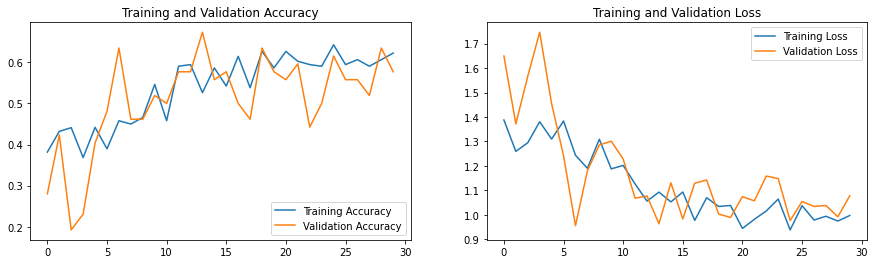

In [ ]:
# plot_metrics(metrics2)

# Model 3:-CNN with GRU with 'ADAM' optimizer

In [ ]:
total_count_frames = 30
selected_frames = 16
gestures = 5
image_height = 120
image_width = 120
img_idx = np.round(np.linspace(0, total_count_frames-1, selected_frames)).astype(int)

In [ ]:
train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())
batch_size = 20

In [ ]:
# curr_dt_time = datetime.datetime.now()
# train_path = '/content/Project_data/train'
# val_path = '/content/Project_data/val'
# num_train_sequences = len(train_doc) # 663
# print('# training sequences =', num_train_sequences)
# num_val_sequences = len(val_doc) # 100
# print('# validation sequences =', num_val_sequences)
# num_epochs = 20
# print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
# from keras.models import Sequential, Model
# from keras.layers import Conv2D,MaxPooling2D
# from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
# from keras.layers.convolutional import Conv3D, MaxPooling3D
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# from keras import optimizers
# from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, Bidirectional


# model = Sequential()
# model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
#                                   input_shape=(len(img_idx), image_height, image_width, 3)))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
 
# model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
 
# model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
 
# model.add(TimeDistributed(Flatten()))

# model.add(GRU(128))
# model.add(Dropout(0.25))
 
# model.add(Dense(128,activation='relu'))
# model.add(Dropout(0.25))
        
# model.add(Dense(5, activation='softmax'))


In [ ]:
# train_generator = generator(train_path, train_doc, batch_size)
# val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
# model_name = 'model_init_exp3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
# if not os.path.exists(model_name):
#     os.mkdir(model_name)
        
# filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# # ModelCheckpoint - saves weight and model after every epoch
# LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
#                       mode="min", epsilon=0.0001,
#                       cooldown=0, min_lr=0.00001) 
# callbacks_list = [checkpoint, LR]

In [ ]:
# if (num_train_sequences%batch_size) == 0:
#     steps_per_epoch = int(num_train_sequences/batch_size)
# else:
#     steps_per_epoch = (num_train_sequences//batch_size) + 1
# if (num_val_sequences%batch_size) == 0:
#     validation_steps = int(num_val_sequences/batch_size)
# else:
#     validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# metrics3 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
# # /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4406 - categorical_accuracy: 0.3575Source path =  /content/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_exp3_2022-08-1216_21_58.067637/model-00001-1.44063-0.35747-2.58562-0.23000.h5
34/34 [==============================] - 147s 4s/step - loss: 1.4406 - categorical_accuracy: 0.3575 - val_loss: 2.5856 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1882 - categorical_accuracy: 0.5686
Epoch 2: saving model to model_init_exp3_2022-08-1216_21_58.067637/model-00002-1.18823-0.56863-1.98792-0.21000.h5
34/34 [==============================] - 38s 1s/step - loss: 1.1882 - categorical_accuracy: 0.5686 - val_loss: 1.9879 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.3821 - categorical_accuracy: 

**Training Accuracy:** 0.68%

**Validation Accuracy:** 0.69%

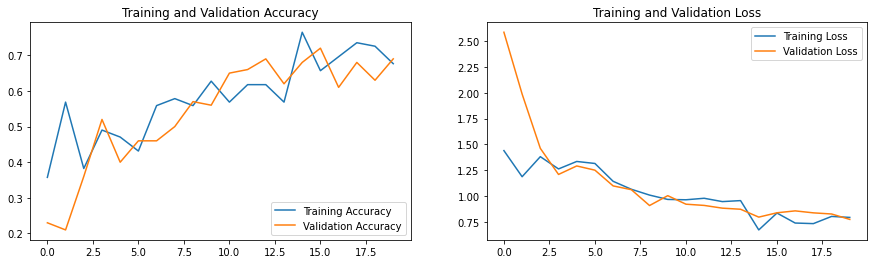

In [ ]:
# plot_metrics(metrics3)

# Model 4:- CNN RNN with mobilenet

In [ ]:
total_count_frames = 30
selected_frames = 16
gestures = 5
image_height = 120
image_width = 120
img_idx = np.round(np.linspace(0, total_count_frames-1, selected_frames)).astype(int)

In [ ]:
batch_size = 5

In [ ]:
curr_dt_time = datetime.datetime.now()
# train_path = '/content/Project_data/train'
# val_path = '/content/Project_data/val'
train_path = '/content/drive/MyDrive/DL_Course_Project/Project_data/train'
val_path = '/content/drive/MyDrive/DL_Course_Project/Project_data/val'
num_train_sequences = len(train_doc) # 663
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc) # 100
print('# validation sequences =', num_val_sequences)
num_epochs = 15
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
        
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(len(img_idx), image_height, image_width, 3)))         
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(128))
model.add(Dropout(0.25))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 16, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init_exp4' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# ModelCheckpoint - saves weight and model after every epoch
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                      mode="min", epsilon=0.0001,
                      cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
metrics4=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/Project_data/train ; batch size = 5
Epoch 1/15
133/133 [==============================] - ETA: 0s - loss: 1.2584 - categorical_accuracy: 0.4887Source path =  /content/Project_data/val ; batch size = 5

Epoch 1: saving model to model_init_exp4_2022-08-1217_06_04.165188/model-00001-1.25841-0.48869-0.76528-0.70000.h5
133/133 [==============================] - 152s 1s/step - loss: 1.2584 - categorical_accuracy: 0.4887 - val_loss: 0.7653 - val_categorical_accuracy: 0.7000 - lr: 0.0010
Epoch 2/15
133/133 [==============================] - ETA: 0s - loss: 1.1103 - categorical_accuracy: 0.5714
Epoch 2: saving model to model_init_exp4_2022-08-1217_06_04.165188/model-00002-1.11028-0.57143-0.83575-0.64000.h5
133/133 [==============================] - 99s 752ms/step - loss: 1.1103 - categorical_accuracy: 0.5714 - val_loss: 0.8357 - val_categorical_accuracy: 0.6400 - lr: 0.0010
Epoch 3/15
133/133 [==============================] - ETA: 0s - loss: 0.9612 - categorical_accurac

**Training Accuracy:** 0.93%

**Validation Accuracy:** 0.87%

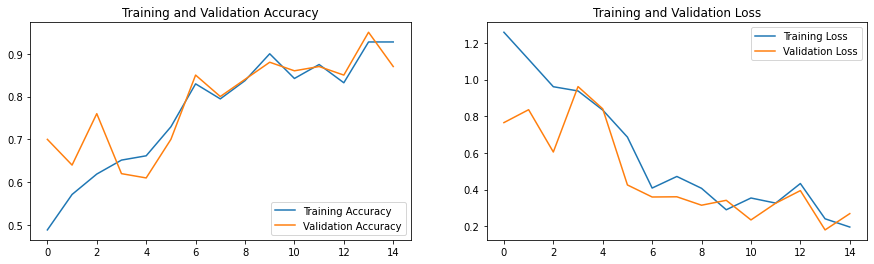

In [ ]:
plot_metrics(metrics4)

Based on the above experiments, the conclusion is that, Conv3D final model is the best:-
> Reason:


*   Training Accuracy : 94%, Validation Accuracy : 89%
*   Number of Parameters is 1,299,941 which is considerably less than all other models and it has achieved this with very less tuning.
*   Loss decreases smoothly with the run of each epoch that too with less model parameters.




